## 1. Adding imports & installing neccessay packages ##

In [ ]:
### run this if using google colab to mount google drive as local storage

from google.colab import drive
import os
drive.mount('/content/gdrive')

repo_path = '/content/gdrive/My Drive/colab/NLP-Bootcamp/'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import collections
%matplotlib inline

# Import modules to calculate accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

## 2. Loading Data ##

In [ ]:
### run below 2 lines of code for setting train & test data path on google colab
trainData = os.path.join(repo_path, 'data/sentiment140_160k_tweets_train.csv')
testData = os.path.join(repo_path, 'data/sentiment140_test.csv')

### run below 3 lines of code for setting train & test data path on local machine
'''
DATA = './data/'
trainData = DATA + 'sentiment140_160k_tweets_train.csv'
testData =  DATA + 'sentiment140_test.csv'
'''

train = pd.read_csv(trainData)
test = pd.read_csv(testData)

train.head()

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.


Looking at distribution of *'positives'* & *'negatives'* samples in train dataset 

In [ ]:
collections.Counter(train['target'])

Counter({'p': 80000, 'n': 79985})

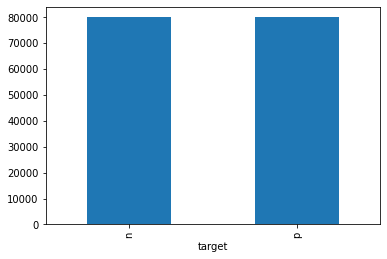

In [ ]:
train.groupby('target').size().plot(kind='bar')

We will find that it is a relatively well-balanced dataset

## 3. Data (Text) Preprocessing ##

In [ ]:
### mapping a dictionary of apostrophe words

appos = {
"aren't" : "are not",
"can't" : "cannot",
"cant" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"im" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"gg" : "going"
}

In [ ]:
import re

def preprocess_text(sentence):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', sentence['text'])
    text = re.sub('@[^\s]+','', text)
    text = text.lower().split()
    reformed = [appos[word] if word in appos else word for word in text]
    reformed = " ".join(reformed) 
    text = re.sub('&[^\s]+;', '', reformed)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    #text = re.sub(' [\w] ', ' ', text)
    return text.strip()

preprocess = train
preprocess['ugc'] = preprocess.apply(preprocess_text, axis=1)

preprocess.head()

,target,ids,user,text,ugc
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ...",anyway and now abby and i share all our crops ...
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...,few times I am trying to leave comments in you...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...,good morning angie I will be in the atl july 8...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ...",had a good day driving up mountains visiting k...
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.,downloading some songs i love lady gaga


## 4. Sentiment Analysis using Deep Learning-based Method: RNN ##

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_features = 4000
#num_words = 20
embedding_size = 256
lstm_dim = 256
batch_size = 64
num_epochs = 10

# Create tokenizer by converting text into sequence of integers
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(preprocess['ugc'].values)

X = tokenizer.texts_to_sequences(preprocess['ugc'].values)
X = sequence.pad_sequences(X)
#X = sequence.pad_sequences(X, maxlen=num_words)
y = pd.get_dummies(preprocess['target']).values

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Define model
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=max_features,
                    output_dim=embedding_size,
                    input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(units=lstm_dim,
               dropout=0.2,
               activation='tanh',
               recurrent_dropout=0.2,
               recurrent_activation='sigmoid',
               return_sequences=True))
model.add(LSTM(units=128,
               dropout=0.2,
               activation='tanh',
               recurrent_dropout=0.2,
               recurrent_activation='sigmoid'))
model.add(Dense(2, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 38, 256)           1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 38, 256)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 38, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,746,690
Trainable params: 1,746,690
Non-trainable params: 0
______________________________________________

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[['accuracy']])

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, shuffle=True)

In [ ]:
# Fit model
history = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=num_epochs, validation_data=(Xtest, ytest))

Epoch 1/10
2000/2000 [==============================] - 699s 346ms/step - loss: 0.4805 - accuracy: 0.7679 - val_loss: 0.4439 - val_accuracy: 0.7926
Epoch 2/10
2000/2000 [==============================] - 702s 351ms/step - loss: 0.4287 - accuracy: 0.8005 - val_loss: 0.4355 - val_accuracy: 0.7964
Epoch 3/10
2000/2000 [==============================] - 690s 345ms/step - loss: 0.4076 - accuracy: 0.8133 - val_loss: 0.4422 - val_accuracy: 0.7967
Epoch 4/10
2000/2000 [==============================] - 684s 342ms/step - loss: 0.3895 - accuracy: 0.8233 - val_loss: 0.4425 - val_accuracy: 0.7979
Epoch 5/10
2000/2000 [==============================] - 677s 339ms/step - loss: 0.3737 - accuracy: 0.8324 - val_loss: 0.4458 - val_accuracy: 0.7996
Epoch 6/10
2000/2000 [==============================] - 674s 337ms/step - loss: 0.3560 - accuracy: 0.8405 - val_loss: 0.4561 - val_accuracy: 0.7929
Epoch 7/10
2000/2000 [==============================] - 674s 337ms/step - loss: 0.3394 - accuracy: 0.8485 - val_

In [ ]:
# Final evaluation of the model
scores = model.evaluate(Xtest, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.52%
